In [1]:
# Imports based on Exercise 5 (Logistic Regression) and Exercise 9 (ANN)
# Reference: Exercise 5 - Week 5: Bayesian inference and linear models
# Reference: Exercise 9 - Week 9: Artificial Neural Networks and Optimization

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report

# Plotting style (from Exercise 5)
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

# Define parameters
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# Data loading and preprocessing
# Reference: Exercise 5 - Part 4: Logistic regression on the Wine dataset
# Adapted for SAHeart dataset

df = pd.read_csv('../data/SAHeart.csv')
# Ensure target and categorical features are numeric (0/1) for sklearn and torch
# chd may be read as string/categorical - convert to numeric int
df['chd'] = pd.to_numeric(df['chd'], errors='coerce').astype(int)
# famhist contains 'Absent'/'Present' - map explicitly to 0/1
df['famhist'] = df['famhist'].map({'Absent': 0, 'Present': 1}).astype(int)

# Display first few rows
df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


# Classification using Logistic Regression and ANN

This notebook implements classification using:
1. **Logistic Regression** (from Exercise 5)
2. **Artificial Neural Network** (from Exercise 9)

Both methods are evaluated using cross-validation (from Exercise 6).

In [3]:
# Prepare data for classification
# Reference: Exercise 5 - Task 4.2: Construct the data matrices X and y
# Reference: Exercise 6 - Cross-validation patterns

# Construct X and y for the classification problem
X = df.drop(columns=['chd'])
y = df['chd']

# Standardize features (important for both LR and ANN)
# Reference: Exercise 5 - Standardization improves logistic regression performance
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Convert target to numeric (0/1) for binary classification
# y may already be numeric, but ensure safe conversion without relying on categorical codes
y_numeric = pd.to_numeric(y, errors='coerce').astype(int)

print(f"Data shape: X = {X_scaled.shape}, y = {y_numeric.shape}")
print(f"Class distribution:\n{y_numeric.value_counts()}")

Data shape: X = (462, 10), y = (462,)
Class distribution:
chd
0    302
1    160
Name: count, dtype: int64


Logistic Regression - 10-Fold CV Results:
Mean Classification Error: 0.2772 ± 0.0367
Mean Accuracy: 0.7228 ± 0.0367


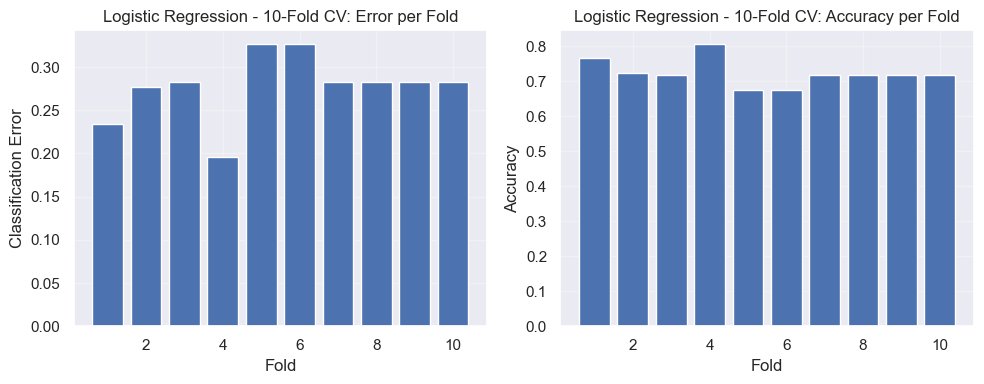

In [4]:
# Logistic Regression with Cross-Validation
# Reference: Exercise 5 - Task 4.3: Fit a logistic regression model
# Reference: Exercise 6 - K-Fold Cross-Validation (Task 2.2)

K = 10  # Number of folds
# Initialize K-Fold Cross-Validation
CV_kfold = KFold(n_splits=K, shuffle=True, random_state=seed)

# Store errors for each fold
fold_errors = []
fold_accuracies = []

# Loop through the folds
for fold, (train_index, test_index) in enumerate(CV_kfold.split(X_scaled)):
    # Split X and y according to the current fold
    # Reference: Exercise 6 - Task 2.3: Split X and y into train/test sets
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y_numeric.iloc[train_index], y_numeric.iloc[test_index]
    
    # Fit logistic regression model
    # Reference: Exercise 5 - Task 4.3: Use sklearn.linear_model.LogisticRegression
    logreg_model = LogisticRegression(random_state=seed, max_iter=1000)
    logreg_model.fit(X_train, y_train)
    
    # Predict labels and probabilities
    # Reference: Exercise 5 - Task 4.3: Use .predict() and .predict_proba()
    y_pred = logreg_model.predict(X_test)
    y_pred_proba = logreg_model.predict_proba(X_test)[:, 1]  # Probability of class 1
    
    # Compute classification error and accuracy
    misclass_rate = np.mean(y_pred != y_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    fold_errors.append(misclass_rate)
    fold_accuracies.append(accuracy)

# Compute mean performance across folds
mean_error = np.mean(fold_errors)
mean_accuracy = np.mean(fold_accuracies)
std_error = np.std(fold_errors)
std_accuracy = np.std(fold_accuracies)

print(f"Logistic Regression - {K}-Fold CV Results:")
print(f"Mean Classification Error: {mean_error:.4f} ± {std_error:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

# Plot fold errors
fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, K+1), fold_errors)
plt.xlabel('Fold')
plt.ylabel('Classification Error')
plt.title(f'Logistic Regression - {K}-Fold CV: Error per Fold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, K+1), fold_accuracies)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title(f'Logistic Regression - {K}-Fold CV: Accuracy per Fold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Logistic Regression - Final Model (trained on full dataset):
Classification Error: 0.2727
Accuracy: 0.7273


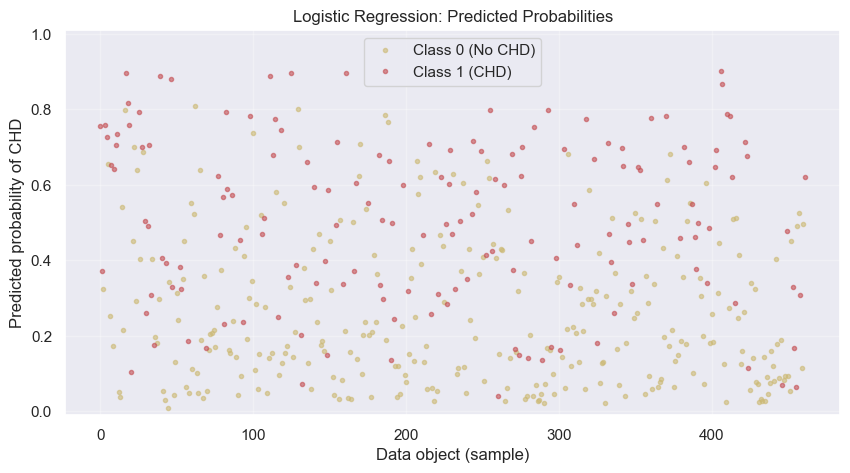

In [5]:
# Train final logistic regression model on full dataset for evaluation
# Reference: Exercise 5 - Task 4.3: Final model evaluation

logreg_final = LogisticRegression(random_state=seed, max_iter=1000)
logreg_final.fit(X_scaled, y_numeric)

# Predict on full dataset
y_pred_lr = logreg_final.predict(X_scaled)
y_pred_proba_lr = logreg_final.predict_proba(X_scaled)[:, 1]

# Compute final metrics
final_accuracy_lr = accuracy_score(y_numeric, y_pred_lr)
final_error_lr = np.mean(y_pred_lr != y_numeric)

print(f"\nLogistic Regression - Final Model (trained on full dataset):")
print(f"Classification Error: {final_error_lr:.4f}")
print(f"Accuracy: {final_accuracy_lr:.4f}")

# Plot predicted probabilities
# Reference: Exercise 5 - Task 4.3: Visualize predicted probabilities
fig = plt.figure(figsize=(10, 5))
class0_ids = np.where(y_numeric == 0)[0]
class1_ids = np.where(y_numeric == 1)[0]
plt.plot(class0_ids, y_pred_proba_lr[class0_ids], ".y", label='Class 0 (No CHD)', alpha=0.6)
plt.plot(class1_ids, y_pred_proba_lr[class1_ids], ".r", label='Class 1 (CHD)', alpha=0.6)
plt.xlabel("Data object (sample)")
plt.ylabel("Predicted probability of CHD")
plt.title("Logistic Regression: Predicted Probabilities")
plt.legend()
plt.ylim(-0.01, 1.01)
plt.grid(True, alpha=0.3)
plt.show()


## Part 2: Artificial Neural Network (ANN)

Using code from **Exercise 9 - Part 3: Training a simple neural network** and **Part 5: Multinomial classification with a neural network**

**Changes made:**
- Adapted from binary classification (XOR dataset) to our CHD classification problem
- Used cross-validation instead of single train/test split
- Applied to real-world dataset instead of synthetic data


In [6]:
# Define neural network architecture
# Reference: Exercise 9 - Task 3.2: Construct the neural network
# Adapted for binary classification (CHD prediction)

def get_model(input_dim, hidden_dim, output_dim):
    """
    Create a neural network model for binary classification.
    Reference: Exercise 9 - Part 3: get_model function
    Changes: Adapted for binary classification with sigmoid output
    """
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True),  # Input layer
        torch.nn.ReLU(),  # Activation function
        torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True),  # Output layer
        torch.nn.Sigmoid()  # Output activation function (for binary classification)
    )

# Define model dimensions
input_dim = X_scaled.shape[1]  # Number of features
hidden_dim = 10  # Number of hidden units (can be tuned)
output_dim = 1  # Binary classification

print(f"Neural Network Architecture:")
print(f"Input dimension: {input_dim}")
print(f"Hidden units: {hidden_dim}")
print(f"Output dimension: {output_dim}")


Neural Network Architecture:
Input dimension: 10
Hidden units: 10
Output dimension: 1


Fold 2/10: Test Loss = 0.6007, Accuracy = 0.6596


Fold 4/10: Test Loss = 0.5061, Accuracy = 0.7609


Fold 6/10: Test Loss = 0.5546, Accuracy = 0.6739


Fold 8/10: Test Loss = 0.5668, Accuracy = 0.6522


Fold 10/10: Test Loss = 0.5432, Accuracy = 0.7174

ANN - 10-Fold CV Results:
Mean Classification Error: 0.2901 ± 0.0423
Mean Accuracy: 0.7099 ± 0.0423


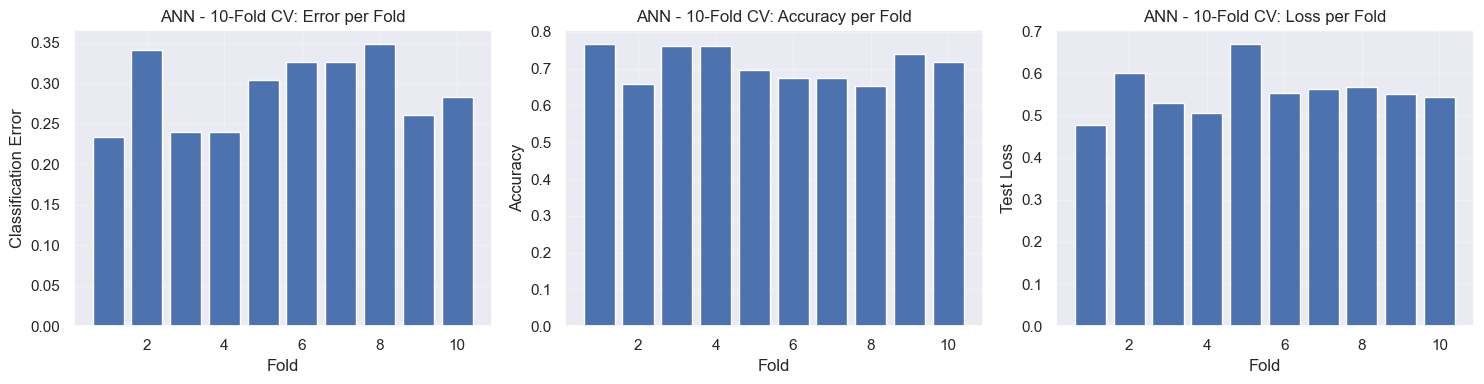

In [7]:
# ANN with Cross-Validation
# Reference: Exercise 9 - Task 3.3: Training loop
# Reference: Exercise 6 - K-Fold Cross-Validation pattern
# Changes: Integrated cross-validation into ANN training

K = 10  # Number of folds
CV_kfold = KFold(n_splits=K, shuffle=True, random_state=seed)

# Store results for each fold
ann_fold_errors = []
ann_fold_accuracies = []
ann_fold_losses = []

# Training parameters
# Reference: Exercise 9 - Task 3.3: Learning rate and epochs
lr = 0.01  # Learning rate (reduced from 0.05 for more stable training)
n_epochs = 1000  # Number of epochs (reduced from 10000 for faster training)

# Loop through the folds
for fold, (train_index, test_index) in enumerate(CV_kfold.split(X_scaled)):
    # Split data
    X_train_fold = X_scaled.iloc[train_index].values
    X_test_fold = X_scaled.iloc[test_index].values
    y_train_fold = y_numeric.iloc[train_index].values
    y_test_fold = y_numeric.iloc[test_index].values
    
    # Convert to torch tensors
    # Reference: Exercise 9 - Task 3.1: Convert to torch tensors
    X_train_torch = torch.tensor(X_train_fold, dtype=torch.float32)
    X_test_torch = torch.tensor(X_test_fold, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train_fold, dtype=torch.float32).reshape(-1, 1)
    y_test_torch = torch.tensor(y_test_fold, dtype=torch.float32).reshape(-1, 1)
    
    # Create model instance
    model = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    
    # Define loss criterion (binary cross-entropy for binary classification)
    # Reference: Exercise 9 - Task 3.3: torch.nn.BCELoss()
    criterion = torch.nn.BCELoss()
    
    # Define optimizer
    # Reference: Exercise 9 - Task 3.3: torch.optim.SGD
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
    
    # Training loop
    # Reference: Exercise 9 - Task 3.3: Training loop structure
    for epoch in range(n_epochs):
        # Set model to training mode
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
    
    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_torch)
        test_loss = criterion(test_outputs, y_test_torch)
        
        # Convert probabilities to predictions
        y_pred_torch = (test_outputs > 0.5).float()
        
        # Compute metrics
        accuracy = (y_pred_torch == y_test_torch).float().mean().item()
        error = 1 - accuracy
    
    ann_fold_errors.append(error)
    ann_fold_accuracies.append(accuracy)
    ann_fold_losses.append(test_loss.item())
    
    if (fold + 1) % 2 == 0:
        print(f"Fold {fold+1}/{K}: Test Loss = {test_loss.item():.4f}, Accuracy = {accuracy:.4f}")

# Compute mean performance
mean_error_ann = np.mean(ann_fold_errors)
mean_accuracy_ann = np.mean(ann_fold_accuracies)
std_error_ann = np.std(ann_fold_errors)
std_accuracy_ann = np.std(ann_fold_accuracies)

print(f"\nANN - {K}-Fold CV Results:")
print(f"Mean Classification Error: {mean_error_ann:.4f} ± {std_error_ann:.4f}")
print(f"Mean Accuracy: {mean_accuracy_ann:.4f} ± {std_accuracy_ann:.4f}")

# Plot fold results
fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.bar(range(1, K+1), ann_fold_errors)
plt.xlabel('Fold')
plt.ylabel('Classification Error')
plt.title(f'ANN - {K}-Fold CV: Error per Fold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.bar(range(1, K+1), ann_fold_accuracies)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title(f'ANN - {K}-Fold CV: Accuracy per Fold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.bar(range(1, K+1), ann_fold_losses)
plt.xlabel('Fold')
plt.ylabel('Test Loss')
plt.title(f'ANN - {K}-Fold CV: Loss per Fold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Epoch [200/1000], Loss: 0.6369
Epoch [400/1000], Loss: 0.6196


Epoch [600/1000], Loss: 0.6013
Epoch [800/1000], Loss: 0.5817


Epoch [1000/1000], Loss: 0.5634

ANN - Final Model (trained on full dataset):
Classification Error: 0.3052
Accuracy: 0.6948


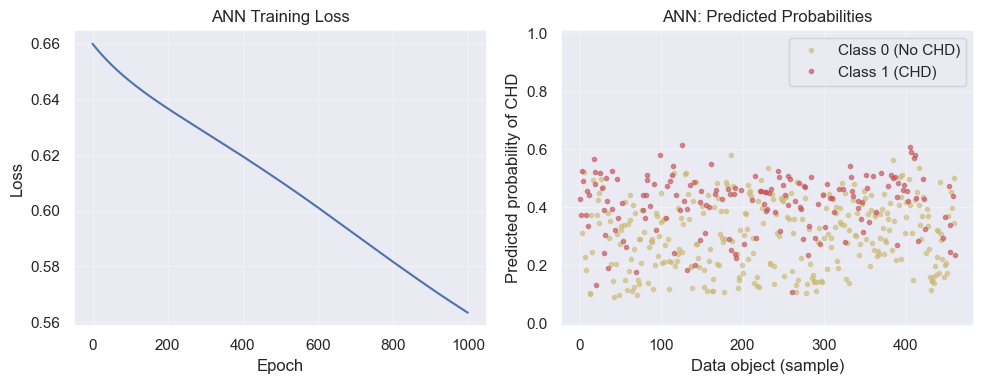

In [8]:
# Train final ANN model on full dataset
# Reference: Exercise 9 - Task 3.3: Final model training
# Changes: Applied to full dataset instead of train/test split

# Convert full dataset to torch tensors
X_full_torch = torch.tensor(X_scaled.values, dtype=torch.float32)
y_full_torch = torch.tensor(y_numeric.values, dtype=torch.float32).reshape(-1, 1)

# Create and train final model
ann_final = get_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(params=ann_final.parameters(), lr=lr)

# Training loop
losses = []
for epoch in range(n_epochs):
    ann_final.train()
    optimizer.zero_grad()
    
    outputs = ann_final(X_full_torch)
    loss = criterion(outputs, y_full_torch)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# Evaluate final model
ann_final.eval()
with torch.no_grad():
    final_outputs = ann_final(X_full_torch)
    final_predictions = (final_outputs > 0.5).float()
    final_accuracy_ann = (final_predictions == y_full_torch).float().mean().item()
    final_error_ann = 1 - final_accuracy_ann

print(f"\nANN - Final Model (trained on full dataset):")
print(f"Classification Error: {final_error_ann:.4f}")
print(f"Accuracy: {final_accuracy_ann:.4f}")

# Plot training loss
fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ANN Training Loss')
plt.grid(True, alpha=0.3)

# Plot predicted probabilities
plt.subplot(1, 2, 2)
final_proba = final_outputs.numpy().flatten()
class0_ids = np.where(y_numeric == 0)[0]
class1_ids = np.where(y_numeric == 1)[0]
plt.plot(class0_ids, final_proba[class0_ids], ".y", label='Class 0 (No CHD)', alpha=0.6)
plt.plot(class1_ids, final_proba[class1_ids], ".r", label='Class 1 (CHD)', alpha=0.6)
plt.xlabel("Data object (sample)")
plt.ylabel("Predicted probability of CHD")
plt.title("ANN: Predicted Probabilities")
plt.legend()
plt.ylim(-0.01, 1.01)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Part 3: Comparison of Methods

Compare Logistic Regression and ANN performance


Comparison of Methods (10-Fold CV):
             Method  Mean Error  Std Error  Mean Accuracy  Std Accuracy
Logistic Regression    0.277151   0.036659       0.722849      0.036659
                ANN    0.290055   0.042316       0.709945      0.042316


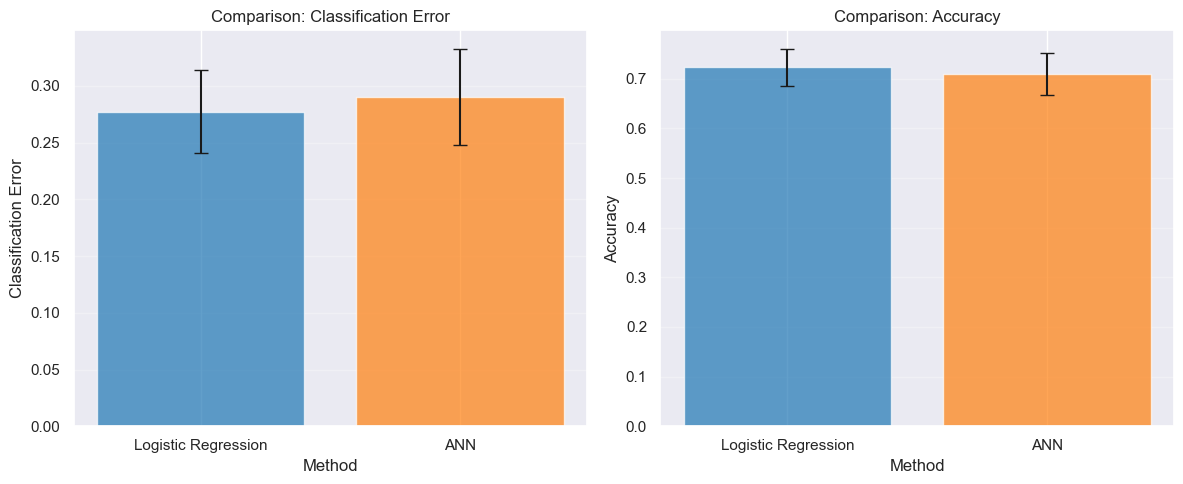

In [9]:
# Compare Logistic Regression and ANN
# Reference: Exercise 6 - Comparison of methods

comparison_data = {
    'Method': ['Logistic Regression', 'ANN'],
    'Mean Error': [mean_error, mean_error_ann],
    'Std Error': [std_error, std_error_ann],
    'Mean Accuracy': [mean_accuracy, mean_accuracy_ann],
    'Std Accuracy': [std_accuracy, std_accuracy_ann]
}

comparison_df = pd.DataFrame(comparison_data)
print("Comparison of Methods (10-Fold CV):")
print(comparison_df.to_string(index=False))

# Visualization
fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
x_pos = np.arange(len(comparison_data['Method']))
plt.bar(x_pos, comparison_data['Mean Error'], yerr=comparison_data['Std Error'], 
        capsize=5, alpha=0.7, color=['tab:blue', 'tab:orange'])
plt.xlabel('Method')
plt.ylabel('Classification Error')
plt.title('Comparison: Classification Error')
plt.xticks(x_pos, comparison_data['Method'])
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
plt.bar(x_pos, comparison_data['Mean Accuracy'], yerr=comparison_data['Std Accuracy'],
        capsize=5, alpha=0.7, color=['tab:blue', 'tab:orange'])
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Comparison: Accuracy')
plt.xticks(x_pos, comparison_data['Method'])
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
